<a href="https://colab.research.google.com/github/Quintaneishon/ImageAnalysis/blob/master/IA_P3_2017631261.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1fo5VGc3fDGcrg-9tudhG4BRuXlN7bXgS" alt="header" style="height:200px;">

# Image Analysis

**Quintana Ruiz Ajitzi Ricardo**

**Boleta: 2017631261**

**Grupo: 3CV6**

03 - Non-linear filters and neighbourhoods


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
%load_ext Cython
import requests
from io import BytesIO

<h3>Some Helpful Functions</h3>

In [0]:
#Displays an array as an image
def im_show(pic,ip):
    height=pic.shape[0]
    width=pic.shape[1]
    
    print(type(pic))
    channels=1
    if pic.ndim>2:
        channels=3
    #ip="nearest"
    plt.figure(figsize=(10,int(10*float(height)/float(width)) ))
    if channels==1:
        plt.imshow(pic,cmap='gray',interpolation=ip,aspect="auto")
    else:
        plt.imshow(pic,interpolation=ip,aspect="auto")

def im_load(file):
    pic=Image.open(file) #Open the image
    print("Image type:"+str(type(pic))) #Displays the type of image (JPEG, BMP, PNG, GIF, etc)
    pic_arr = np.asarray(pic) #converts the image to an Numpy Array
    print("Dimentions"+str(pic_arr.shape)) #(height,width,#of channels)
    pic_channels=1
    if pic_arr.ndim>2:
        pic_channels=3
    print("Channels:"+str(pic_channels))
    #im_show(pic_arr)
    return pic_arr

def grayscale(pic):
    height=pic.shape[0]
    width=pic.shape[1]
    
    channels=1
    if pic.ndim==3:
        channels=pic.shape[2]
    
    if channels==1:
        return pic

    factor=np.array([0.24,0.65,0.11])
    if channels==4:
        factor=np.array([0.24,0.65,0.11,1])

    pic2=np.dot(pic.astype(dtype=np.float),factor)

    return pic2.astype(dtype=np.uint8)

def noise(img, salt, pepper):
    height=img.shape[0]
    width=img.shape[1]  
    img_r=np.asarray(img.copy(),order="C")
    
    hw=height*width
    
    if salt>0 and salt<=1:
        npixels=int(float(hw)*salt)
        for i in range(npixels):
            x = np.random.randint(0,width,1)
            y = np.random.randint(0,height,1)
            img_r[y[0],x[0]]=255
            
        
    if pepper>0 and pepper<=1:
        npixels=int(float(hw)*pepper)
        for i in range(npixels):
            x = np.random.randint(0,width,1)
            y = np.random.randint(0,height,1)
            img_r[y[0],x[0]]=0
    
    return img_r

Image type:<class 'PIL.PngImagePlugin.PngImageFile'>
Dimentions(512, 512, 3)
Channels:3
CPU times: user 10.3 ms, sys: 3 µs, total: 10.3 ms
Wall time: 10.4 ms
(512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
CPU times: user 363 ms, sys: 2.05 ms, total: 365 ms
Wall time: 357 ms
<class 'numpy.ndarray'>


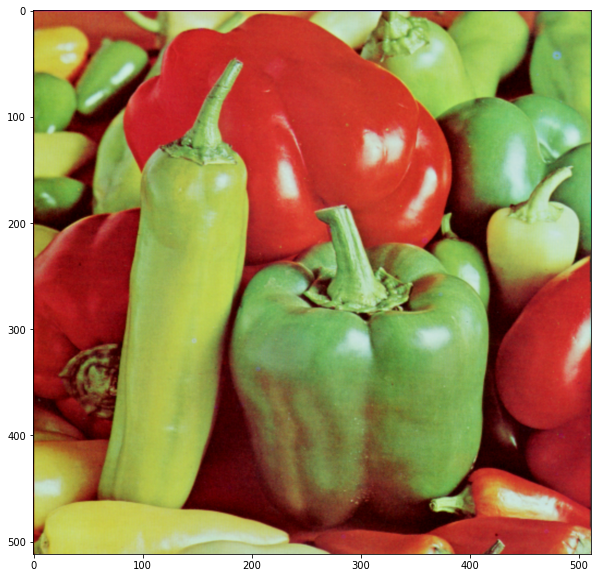

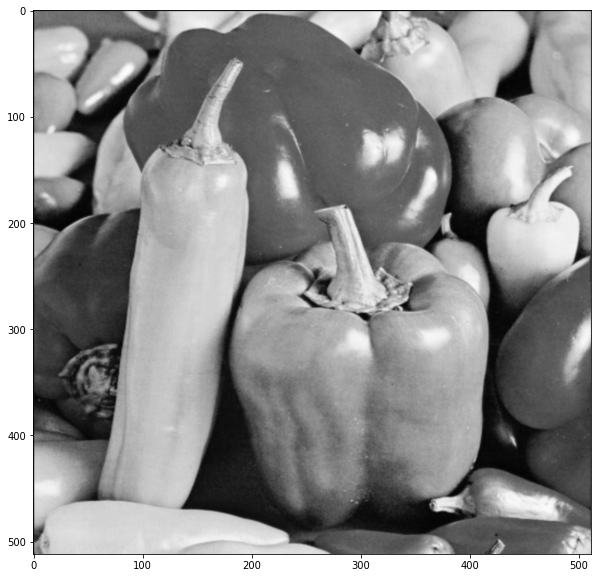

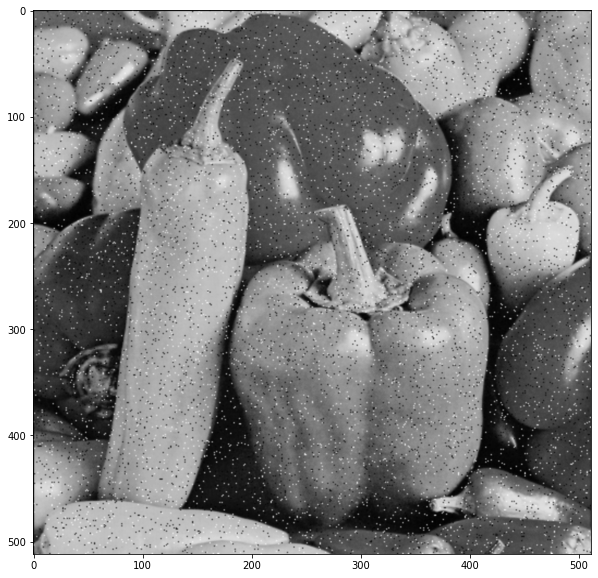

In [0]:
url="https://drive.google.com/uc?id=1HCVHyrLztG3gCqn5uITCMEcJ0J-t6UDY" #peppers.png
#url = "https://drive.google.com/uc?id=19zyR22cAa68mnCUWKiiz8onN3J0tHTA9" #concert
response = requests.get(url)
pic1=im_load(BytesIO(response.content))
%time pic1_gray=grayscale(pic1)
print(pic1_gray.shape)
im_show(pic1,"bicubic")
im_show(pic1_gray,"bicubic")
%time pic1_gray_noised=noise(pic1_gray,0.02,0.02)
im_show(pic1_gray_noised,"bicubic")

In [0]:
%%cython -a
import numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)

def median_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.median(t_arr)
      img_r[y,x]=int(res)

  return img_r

def max_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.max(t_arr)
      img_r[y,x]=int(res)

  return img_r

def min_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.min(t_arr)
      img_r[y,x]=int(res)

  return img_r

def average_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.average(t_arr)
      img_r[y,x]=int(res)

  return img_r

[[0.  0.2 0. ]
 [0.2 0.2 0.2]
 [0.  0.2 0. ]]
CPU times: user 12.1 s, sys: 11 ms, total: 12.2 s
Wall time: 12.2 s
CPU times: user 1.67 s, sys: 979 µs, total: 1.67 s
Wall time: 1.68 s
CPU times: user 1.68 s, sys: 4.05 ms, total: 1.69 s
Wall time: 1.68 s
CPU times: user 2.25 s, sys: 2.98 ms, total: 2.25 s
Wall time: 2.25 s
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


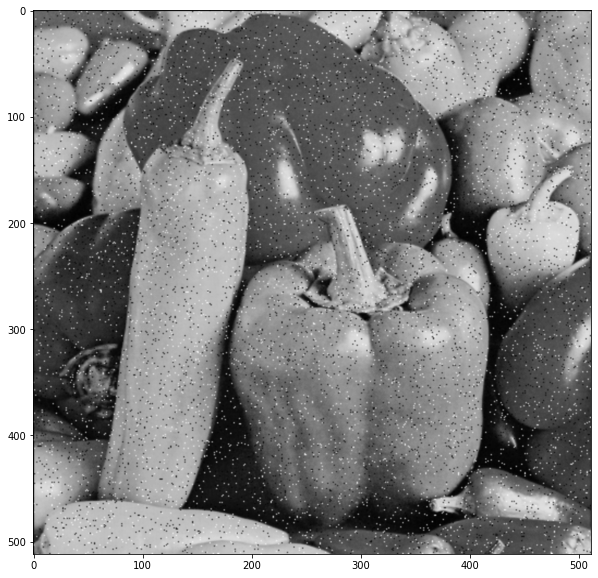

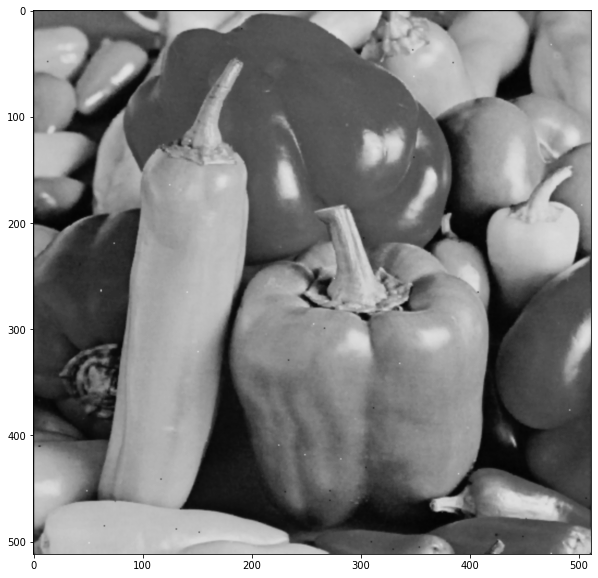

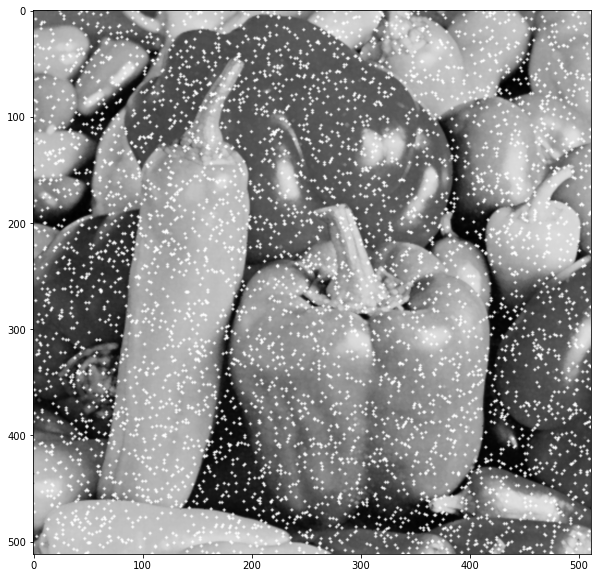

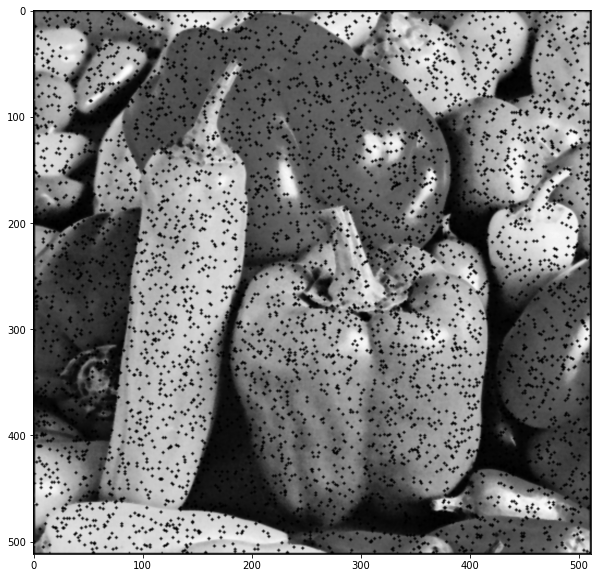

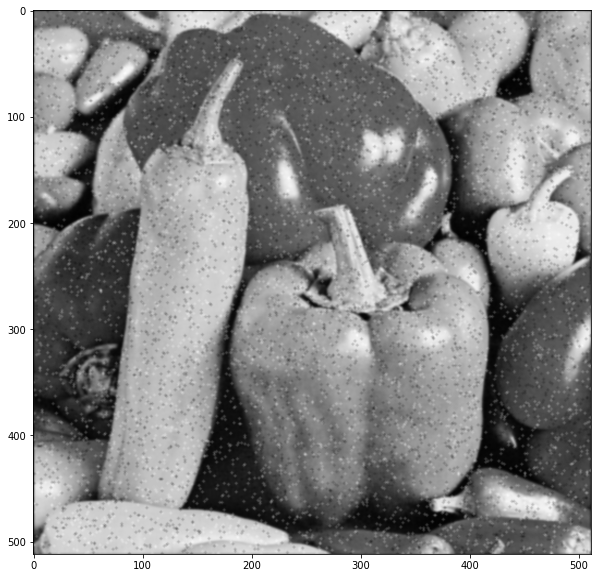

In [0]:
mask1 = np.array([[0.0,0.2,0.0],
                  [0.2,0.2,0.2],
                  [0.0,0.2,0.0]])
mask2 = np.array([[-1,0,-1],
                  [0,0,0],
                  [-1,0,-1]])

omX = 1
omY = 1
print(mask1)
%time picRes1=median_filter(pic1_gray_noised,mask1,omX,omY)
%time picRes2=max_filter(pic1_gray_noised,mask1,omX,omY)
%time picRes3=min_filter(pic1_gray_noised,mask1,omX,omY)
%time picRes4=average_filter(pic1_gray_noised,mask1,omX,omY)

im_show(pic1_gray_noised,"bicubic")
im_show(picRes1,"bicubic")
im_show(picRes2,"bicubic")
im_show(picRes3,"bicubic")
im_show(picRes4,"bicubic")